## System: Rating classification system (Hệ thống phân loại độ tuổi theo anime)
<details>
  <summary><h3 style="color: #EFD1B4;" id="table_content">Table of Contents</h3></summary>
  
  - Introduction
  - Loading and Understand Data
  - Feature Engineering
  - Text Processing
  - Converting Categorical Variables
  - Imbalanced Data Handling
  - Build Models
  - Models Comparing
</details>

<h2 style="color: #EFD1B4;" id="introduction">Introduction</h2>

Anime, like any form of entertainment, is often categorized based on its suitability for different age groups. These classifications help guide viewers in selecting content that aligns with their preferences and age-appropriate content. In this system, anime is rated according to various content considerations such as <span style="color: pink;">Synopsis, Genres, Type, Studios, Source, Popularity, Favorites, Scored By, Members</span>.

The classification system for anime ratings includes the following categories:
- `G - All Ages`: This rating indicates that the anime is suitable for viewers of all ages
- `PG - Children`: Anime with this rating is intended for children, though it may contain some mild peril, animated violence, or themes that are suitable for a younger audience
- `PG-13 - Teens 13 or older`: This rating is for anime that is suitable for viewers aged 13 and above.
- `R - 17+ (violence & profanity)`: Anime rated R typically contains content that is intended for mature audiences.
- `R+ - Mild Nudity`: Anime rated R+ includes content with mild nudity or sexual themes but is typically not explicit.
- `Rx - Hentai`: Rx is the highest rating and indicates that the anime contains explicit adult content, such as pornography or explicit sexual themes.

<h2 style="color: #EFD1B4;" id="loading_and_under_standing_data">Loading and Understanding Data</h2>

In [1]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.metrics import r2_score, confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import mean_squared_error
from imblearn.combine import SMOTEENN

from PATHS import HOME, DATASET_PATH, ANIME_DATASET_2023, DATA_PREPROCESSING

We should check out the environment or configuration paths and variables

In [2]:
print('HOME', HOME)
print('DATASET FOLDER', DATASET_PATH)
print('ANIME DATASET 2023', ANIME_DATASET_2023)
print('DATA PREPROCESSING', DATA_PREPROCESSING)

HOME d:\Data Science Programming\Project
DATASET FOLDER d:\Data Science Programming\Project\raw_animes_dataset
ANIME DATASET 2023 d:\Data Science Programming\Project\raw_animes_dataset\anime-dataset-2023.csv
DATA PREPROCESSING d:\Data Science Programming\Project\Data Preprocessing


For text preprocessing, we will download necessary NLTK datasets for text processing ("Synopsis, Genres, Studios" columns)

In [3]:
nltk.download('stopwords')  # Downloads a list of common stopwords (e.g., "the", "is") that are often removed in text preprocessing
nltk.download('wordnet')  # Downloads the WordNet corpus, which is used for lemmatization
nltk.download('punkt')  # Downloads the Punkt tokenizer models used for tokenizing text into words or sentences

# Initialize the WordNet lemmatizer, which will be used to reduce words to their base form (e.g., "running" -> "run")
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to C:\Users\MINH
[nltk_data]     HUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MINH
[nltk_data]     HUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\MINH
[nltk_data]     HUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now, loading data from 'anime-data-preprocessing.csv' file

In case you fail to load, just check path to this file

In [4]:
anime_clean_df = pd.read_csv(os.path.join(DATA_PREPROCESSING, 'anime-data-preprocessing.csv'))
anime_clean_df

,Name,Score,Genres,Synopsis,Type,Episodes,Producers,Studios,Source,Time per ep (Min),Rating,Rank,Popularity,Favorites,Scored By,Members,Released date,Completed date
0,Fullmetal Alchemist: Brotherhood,9.10,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,64.0,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,24.00,R - 17+ (violence & profanity),1,3,217606,2020030,3176556,2009-04-05,2010-07-04
1,Steins;Gate,9.07,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,24.0,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,24.00,PG-13 - Teens 13 or older,2,13,182964,1336233,2440369,2011-04-06,2011-09-14
2,Bleach: Sennen Kessen-hen,9.07,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,13.0,"TV Tokyo, Aniplex, Dentsu, Shueisha",Pierrot,Manga,24.00,R - 17+ (violence & profanity),3,464,17999,213872,445198,2022-10-11,2022-12-27
3,Gintama°,9.06,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,51.0,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,24.00,PG-13 - Teens 13 or older,4,331,15947,237957,595767,2015-04-08,2016-03-30
4,Shingeki no Kyojin Season 3 Part 2,9.05,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,10.0,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,23.00,R - 17+ (violence & profanity),5,24,55245,1471825,2104016,2019-04-29,2019-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13829,Kokuhaku,2.30,Horror,"Beside a certain building, a girl appears to m...",ONA,1.0,UNKNOWN,UNKNOWN,Original,0.67,R - 17+ (violence & profanity),13830,7105,17,4904,6697,2015-08-27,2015-08-27
13830,Hametsu no Mars,2.22,"Horror, Sci-Fi",Several months after a probe returning from Ma...,OVA,1.0,"Idea Factory, King Records, Design Factory",WAO World,Visual novel,19.00,R - 17+ (violence & profanity),13831,2512,295,47630,65622,2005-07-06,2005-07-06
13831,Tsui no Sora,2.22,Hentai,"After the sudden death of a student, mysteriou...",OVA,1.0,Obtain Future,UNKNOWN,Visual novel,23.00,Rx - Hentai,13832,7563,24,3436,5713,2002-08-10,2002-08-10
13832,Utsu Musume Sayuri,1.98,"Avant Garde, Comedy",Sayuri is a curious creature who lives on her ...,OVA,1.0,UNKNOWN,UNKNOWN,Original,3.00,R+ - Mild Nudity,13833,4492,50,15873,20789,2003-01-01,2003-01-01


We can see the datasets has 13834 rows and 18 columns totally, but to be sure, we should check by `.shape`

In [5]:
anime_clean_df.shape

(13834, 18)

Now check some information of dataset by `.info()`

In [6]:
anime_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               13834 non-null  object 
 1   Score              13834 non-null  float64
 2   Genres             13834 non-null  object 
 3   Synopsis           13834 non-null  object 
 4   Type               13834 non-null  object 
 5   Episodes           13834 non-null  float64
 6   Producers          13834 non-null  object 
 7   Studios            13834 non-null  object 
 8   Source             13834 non-null  object 
 9   Time per ep (Min)  13834 non-null  float64
 10  Rating             13834 non-null  object 
 11  Rank               13834 non-null  int64  
 12  Popularity         13834 non-null  int64  
 13  Favorites          13834 non-null  int64  
 14  Scored By          13834 non-null  int64  
 15  Members            13834 non-null  int64  
 16  Released date      138

- All of columns has 13834 value non-null, this is the same with the number of rows, so it has no empty or NaN values
- The object group consists columns: <span style="color: pink;">Name, Genres, Synopsis, Type, Producers, Studios, Source, Rating, Released date, Completed date</span>.
- The numeric group consists columns: <span style="color: pink;">Score, Episodes, Time per ep (Min), Rank, Popularity, Favorites, Scored By, Member</span>.

In [7]:
anime_clean_df.describe()

,Score,Episodes,Time per ep (Min),Rank,Popularity,Favorites,Scored By,Members
count,13834.000000,13834.000000,13834.000000,13834.000000,13834.000000,13834.000000,1.383400e+04,1.383400e+04
mean,6.450098,11.893668,26.627488,6917.500000,7520.569177,773.679774,3.381713e+04,6.571856e+04
std,0.926846,46.403213,25.478353,3993.676147,4620.368066,5818.029723,1.240178e+05,2.058437e+05
min,1.850000,1.000000,0.100000,1.000000,1.000000,0.000000,1.000000e+02,1.800000e+02
25%,5.830000,1.000000,10.000000,3459.250000,3544.250000,2.000000,5.282500e+02,1.644250e+03
50%,6.470000,2.000000,24.000000,6917.500000,7289.000000,10.000000,2.339500e+03,6.300000e+03
75%,7.130000,12.000000,27.000000,10375.750000,11212.750000,81.000000,1.432375e+04,3.460975e+04
max,9.100000,3057.000000,168.000000,13834.000000,19191.000000,217606.000000,2.660903e+06,3.744541e+06


We can draw a brief analysis of each column in the dataset:
- <span style="color: pink">Score</span>:
    - The average score is 6.45 with a standard deviation of 0.93, indicating that most anime scores are relatively close to each other.
    - The lowest score is 1.85 and the highest is 9.1, showing a wide range, but most scores tend to be between 5 and 7.
- <span style="color: pink">Episodes</span>:
    - The average number of episodes is about 11.89, but there is a large variation with a standard deviation of 46.4, likely due to some anime having an extraordinarily high number of episodes (over 3000).
    - The minimum number of episodes is 1, and the maximum is 3057, with many anime having only 1 or 2 episodes.
- <span style="color: pink">Time per ep (Min)</span>:
    - The average time per episode is 26.6 minutes. However, there is a large spread with a standard deviation of 25.48 minutes, indicating that some episodes are very long or short.
    - The shortest episode is 0.1 minutes (possibly a very short anime), and the longest is 168 minutes (an exceptionally long episode).
- <span style="color: pink">Rank</span>:
    - The average rank is 6917, with the lowest rank being 1 and the highest rank being 13834. This suggests that not all anime have the same level of popularity.
- <span style="color: pink">Popularity</span>:
    - The average popularity is 7520, with a standard deviation of 4620. Some anime are extremely popular (up to 19191), while others have much lower popularity.
- <span style="color: pink">Favorites</span>:
    - The average number of favorites is 773, but there is significant variation (standard deviation of 5818), with some anime having hundreds of thousands of favorites (up to 217606).
- <span style="color: pink">Scored By</span>:
    - The average number of ratings is 33,817. There is a large spread in the data (standard deviation of 124,018), meaning some anime have millions of ratings, while others have relatively few.
- <span style="color: pink">Members</span>:
    - The average number of members is 65,718, with a large variation (standard deviation of 205,843). Some anime have millions of members, while others have only a few thousand.

<h2 style="color: #EFD1B4;" id="feature_engineering">Feature Engineering</h2>

Although dataset file has no empty or NaN value, but it can has unvalues value as `UNKNOWN`, `Unknown`, we have to handle it

---

Check unique values in <span style="color: pink">Rating</span> column

In [8]:
unique_rating_values = anime_clean_df['Rating'].unique()
print('The rating columns has unique values: \n', unique_rating_values)
print('The rating columns has', len(unique_rating_values), 'unique values')

The rating columns has unique values: 
 ['R - 17+ (violence & profanity)' 'PG-13 - Teens 13 or older'
 'R+ - Mild Nudity' 'PG - Children' 'G - All Ages' 'Rx - Hentai']
The rating columns has 6 unique values


Good! so the <span style="color: pink">Rating</span> columns has 6 unique values and has no `UNKNOWN` or `Unknown` value

---

Because we work on attributes <span style="color: pink;">Synopsis, Genres, Type, Studios, Source, Popularity, Favorites, Scored By, Members</span>, so we should drop unecessary other attributes

In [9]:
anime_clean_df.drop(columns=['Name', 'Score', 'Episodes', 'Producers', 'Time per ep (Min)', 'Rank', 'Released date', 'Completed date'], inplace=True)
anime_clean_df.keys()

Index(['Genres', 'Synopsis', 'Type', 'Studios', 'Source', 'Rating',
       'Popularity', 'Favorites', 'Scored By', 'Members'],
      dtype='object')

Now we should check `UNKNOWN` and `Unknown` in <span style="color: pink">Studios, Sources</span> columns and handle it

In [10]:
unknown_studios_count = anime_clean_df[anime_clean_df['Studios']=='UNKNOWN'].shape[0]
unknown_studios_ratio = unknown_studios_count/anime_clean_df.shape[0] * 100

print('Unknown studios ratio is: ', unknown_studios_ratio)

Unknown studios ratio is:  16.95099031371982


The unknown studios ratio is `~16.9%`. So we should drop columns has `UNKNOWN` value

In [11]:
anime_clean_df = anime_clean_df[anime_clean_df['Studios'] != 'UNKNOWN']
anime_clean_df

,Genres,Synopsis,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,Members
0,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030,3176556
1,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,White Fox,Visual novel,PG-13 - Teens 13 or older,13,182964,1336233,2440369
2,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,Pierrot,Manga,R - 17+ (violence & profanity),464,17999,213872,445198
3,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957,595767
4,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,Wit Studio,Manga,R - 17+ (violence & profanity),24,55245,1471825,2104016
...,...,...,...,...,...,...,...,...,...,...
13818,"Action, Sci-Fi","Based on a 1980 manga by Mikuriya Satomi, this...",OVA,Filmlink International,Manga,PG-13 - Teens 13 or older,8299,13,2475,4570
13822,"Action, Sci-Fi","After being hit by a truck in the year 2014, A...",TV,Visual Flight,Manga,PG-13 - Teens 13 or older,2234,294,41926,79139
13827,"Action, Comedy, Ecchi",Computer-animated gag shorts about two female ...,OVA,Production I.G,Original,R+ - Mild Nudity,6927,40,4633,7176
13830,"Horror, Sci-Fi",Several months after a probe returning from Ma...,OVA,WAO World,Visual novel,R - 17+ (violence & profanity),2512,295,47630,65622


In [12]:
anime_clean_df.shape

(11489, 10)

Now the dataset has 11489 rows and 10 columns

---

In [13]:
unknown_source_count = anime_clean_df[anime_clean_df['Source']=='Unknown'].shape[0]
unknown_source_ratio = unknown_source_count/anime_clean_df.shape[0] * 100

print('Unknown source ratio is: ', unknown_source_ratio)

Unknown source ratio is:  8.068587344416398


The unknown source ratio is `~8.06%`. So we should drop columns has `Unknown` value

In [14]:
anime_clean_df = anime_clean_df[anime_clean_df['Source'] != 'Unknown']
anime_clean_df

,Genres,Synopsis,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,Members
0,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030,3176556
1,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,White Fox,Visual novel,PG-13 - Teens 13 or older,13,182964,1336233,2440369
2,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,Pierrot,Manga,R - 17+ (violence & profanity),464,17999,213872,445198
3,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957,595767
4,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,Wit Studio,Manga,R - 17+ (violence & profanity),24,55245,1471825,2104016
...,...,...,...,...,...,...,...,...,...,...
13818,"Action, Sci-Fi","Based on a 1980 manga by Mikuriya Satomi, this...",OVA,Filmlink International,Manga,PG-13 - Teens 13 or older,8299,13,2475,4570
13822,"Action, Sci-Fi","After being hit by a truck in the year 2014, A...",TV,Visual Flight,Manga,PG-13 - Teens 13 or older,2234,294,41926,79139
13827,"Action, Comedy, Ecchi",Computer-animated gag shorts about two female ...,OVA,Production I.G,Original,R+ - Mild Nudity,6927,40,4633,7176
13830,"Horror, Sci-Fi",Several months after a probe returning from Ma...,OVA,WAO World,Visual novel,R - 17+ (violence & profanity),2512,295,47630,65622


In [15]:
anime_clean_df.shape

(10562, 10)

Now the dataset has 10562 rows and 10 columns

---

<h2 style="color: #EFD1B4;" id="text_processing">Text Processing</h2>

The text columns consists of
- <span style="color: pink">Synopsis</span>: is a brief description of the main plot of each anime, providing users with an overview of the story, characters, and setting without the need to watch the entire series. It highlights the key themes and distinctive elements of the anime.
- <span style="color: pink">Genres</span>: refer to the primary categories that classify each anime, such as action, romance, science fiction, fantasy, comedy, and many others. These genres help users easily search for anime based on their interests and explore popular or specific types of anime.

---

Show some lines of <span style="color: pink">Synopsis</span> columns

In [16]:
anime_clean_df['Synopsis'].sample(10, random_state=5)

580      Now that Kumiko Oumae has enrolled in Kitauji ...
1116     This two-part OVA is a series of shorts in rel...
10896    The Bakumatsu was an era in which the souls of...
2925     Joe Shimamura and his companions may seem like...
10064             No description available for this anime.
111      Having spent Christmas camping with her new fr...
11798    Adolpho has his heart set on a life of service...
12563    A young girl starting to put on make-up inadve...
9660     Recap episodes of Magia Record: Mahou Shoujo M...
8854     Sora was lying in front of a hospital. He was ...
Name: Synopsis, dtype: object

Although columns has no empty or NaN value, but it can has unvalues value as `No description available for this anime.`, we have to handle it

In [17]:
anime_clean_df[anime_clean_df['Synopsis'] == 'No description available for this anime.']

,Genres,Synopsis,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,Members
923,"Comedy, Slice of Life",No description available for this anime.,Special,Shaft,4-koma manga,PG-13 - Teens 13 or older,5179,10,7278,14601
956,Comedy,No description available for this anime.,Movie,GoHands,4-koma manga,R - 17+ (violence & profanity),3813,49,8149,30035
1438,"Comedy, Romance",No description available for this anime.,OVA,feel.,Light novel,PG-13 - Teens 13 or older,2005,489,10462,94326
1476,Hentai,No description available for this anime.,OVA,T-Rex,Manga,Rx - Hentai,7212,75,2929,6456
1623,"Drama, Fantasy, Slice of Life",No description available for this anime.,Movie,Studio Gokumi,Light novel,PG-13 - Teens 13 or older,5182,11,5270,14555
...,...,...,...,...,...,...,...,...,...,...
13037,Hentai,No description available for this anime.,OVA,Studio Jam,Visual novel,Rx - Hentai,12692,0,247,981
13062,Comedy,No description available for this anime.,Music,Toei Animation,Picture book,PG - Children,15367,1,211,450
13239,Hentai,No description available for this anime.,OVA,Image House,Visual novel,Rx - Hentai,13395,0,202,797
13283,"Supernatural, Hentai",No description available for this anime.,OVA,Studio 9 Maiami,Visual novel,Rx - Hentai,9118,2,1096,3379


So in dataset has 283 rows with `No description available for this anime.` values, we will drop them out of dataset

In [18]:
filtering = anime_clean_df[anime_clean_df['Synopsis'] == "No description available for this anime."]
anime_clean_df.drop(filtering.index,inplace=True)
anime_clean_df.reset_index(drop=True, inplace=True)
anime_clean_df

C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_15432\345881173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_clean_df.drop(filtering.index,inplace=True)


,Genres,Synopsis,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,Members
0,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030,3176556
1,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,White Fox,Visual novel,PG-13 - Teens 13 or older,13,182964,1336233,2440369
2,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,Pierrot,Manga,R - 17+ (violence & profanity),464,17999,213872,445198
3,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957,595767
4,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,Wit Studio,Manga,R - 17+ (violence & profanity),24,55245,1471825,2104016
...,...,...,...,...,...,...,...,...,...,...
10274,"Action, Sci-Fi","Based on a 1980 manga by Mikuriya Satomi, this...",OVA,Filmlink International,Manga,PG-13 - Teens 13 or older,8299,13,2475,4570
10275,"Action, Sci-Fi","After being hit by a truck in the year 2014, A...",TV,Visual Flight,Manga,PG-13 - Teens 13 or older,2234,294,41926,79139
10276,"Action, Comedy, Ecchi",Computer-animated gag shorts about two female ...,OVA,Production I.G,Original,R+ - Mild Nudity,6927,40,4633,7176
10277,"Horror, Sci-Fi",Several months after a probe returning from Ma...,OVA,WAO World,Visual novel,R - 17+ (violence & profanity),2512,295,47630,65622


In [19]:
anime_clean_df.shape

(10279, 10)

After drop rows, our dataset has 10279 rows and 10 columns

---

Now we will remove punctuation and special characters from the <span style="color: pink">Synopsis</span> column

In [20]:
# Extract values in 'Synopsis' columm into synopsis_value_df
synopsis_value_df = pd.DataFrame(anime_clean_df['Synopsis'])
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].str.replace(r'[^\w\s]', "")
synopsis_value_df

,Synopsis
0,After a horrific alchemy experiment goes wrong...
1,Eccentric scientist Rintarou Okabe has a never...
2,Substitute Soul Reaper Ichigo Kurosaki spends ...
3,"Gintoki, Shinpachi, and Kagura return as the f..."
4,Seeking to restore humanity's diminishing hope...
...,...
10274,"Based on a 1980 manga by Mikuriya Satomi, this..."
10275,"After being hit by a truck in the year 2014, A..."
10276,Computer-animated gag shorts about two female ...
10277,Several months after a probe returning from Ma...


Next, we make tokenizes the text in the <span style="color: pink">Synopsis</span> column by breaking it down into individual words.

Example
- Before the operation: "The hero wins the battle."
- After the operation: ['The', 'hero', 'wins', 'the', 'battle', '.']

In [22]:
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].apply(word_tokenize)
synopsis_value_df['Synopsis']

0        [After, a, horrific, alchemy, experiment, goes...
1        [Eccentric, scientist, Rintarou, Okabe, has, a...
2        [Substitute, Soul, Reaper, Ichigo, Kurosaki, s...
3        [Gintoki, ,, Shinpachi, ,, and, Kagura, return...
4        [Seeking, to, restore, humanity, 's, diminishi...
                               ...                        
10274    [Based, on, a, 1980, manga, by, Mikuriya, Sato...
10275    [After, being, hit, by, a, truck, in, the, yea...
10276    [Computer-animated, gag, shorts, about, two, f...
10277    [Several, months, after, a, probe, returning, ...
10278    [When, a, mysterious, entity, suddenly, appear...
Name: Synopsis, Length: 10279, dtype: object

Now, each entry in the 'Synopsis' column will be transformed from a single string into a list of words (tokens).

---

Now, we should deeply handle this column for achieve good performance model

In [23]:
# Uses the NLTK library to get a list of common English stopwords (e.g., "the", "is", "in", "on") that usually don't carry significant meaning for text analysis.
eng_stopwords = stopwords.words('english') 

# Remove stopwords and convert all words to lowercase:
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].dropna().apply(lambda words: [word.lower() for word in words if word.lower() not in eng_stopwords])

# Remove punctuation:
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].apply(lambda x: [word.strip(string.punctuation) for word in x])

# Apply lemmatization:
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove words with length 1 or less:
synopsis_value_df['Synopsis'] = synopsis_value_df['Synopsis'].apply(lambda x: [word for word in x if len(word) > 1])
synopsis_value_df['Synopsis']

0        [horrific, alchemy, experiment, go, wrong, elr...
1        [eccentric, scientist, rintarou, okabe, never-...
2        [substitute, soul, reaper, ichigo, kurosaki, s...
3        [gintoki, shinpachi, kagura, return, fun-lovin...
4        [seeking, restore, humanity, diminishing, hope...
                               ...                        
10274    [based, 1980, manga, mikuriya, satomi, adaptat...
10275    [hit, truck, year, 2014, akira, natsume, awake...
10276    [computer-animated, gag, short, two, female, a...
10277    [several, month, probe, returning, mar, burn, ...
10278    [mysterious, entity, suddenly, appears, center...
Name: Synopsis, Length: 10279, dtype: object

We check count of each word in <span style="color: pink">Synopsis</span> columns

In [24]:
synopsis_value_df['Synopsis'].explode().value_counts()[:30]

Synopsis
source     3788
one        3271
world      3042
school     2912
girl       2827
life       2773
new        2379
however    2293
friend     2186
find       1967
day        1902
year       1819
time       1608
two        1563
student    1547
ann        1448
take       1426
high       1346
young      1317
power      1278
first      1267
story      1258
human      1249
must       1193
way        1174
love       1160
make       1146
begin      1144
get        1141
episode    1139
Name: count, dtype: int64

Because model just work on numeric column, so we uses TfidfVectorizer to convert anime descriptions (<span style="color: pink">Synopsis</span>) into numerical vectors, allowing the computer to understand and analyze them. It removes unimportant words, keeps only the 500 most important words (or n-grams), and combines unigrams, bigrams, and trigrams to improve the quality of the text features.

In [25]:
tfidfvectorsizer = TfidfVectorizer(max_features=500,stop_words='english',ngram_range=(1,3))
word_array = tfidfvectorsizer.fit_transform(anime_clean_df['Synopsis'])
print(word_array.toarray()[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.19312941 0.
 0.         0.         0.42099179 0.         0.19441996 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.21996144 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

Now, we convert the TF-IDF matrix into a Pandas DataFrame where:
- Each row represents an anime.
- Each column represents a word or n-gram.
- The cell values show the TF-IDF scores, which represent the importance of each word/n-gram in the context of the specific anime synopsis.

In [26]:
tfidf_values = pd.DataFrame(word_array.toarray(), columns=tfidfvectorsizer.get_feature_names_out())
print(tfidf_values)

       abilities  ability      able  academy  accident    action  actually  \
0            0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
1            0.0      0.0  0.172385      0.0   0.00000  0.000000       0.0   
2            0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
3            0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
4            0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
...          ...      ...       ...      ...       ...       ...       ...   
10274        0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
10275        0.0      0.0  0.000000      0.0   0.15757  0.159509       0.0   
10276        0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
10277        0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   
10278        0.0      0.0  0.000000      0.0   0.00000  0.000000       0.0   

       adventure  adventures  age  ...    works     world     y

Now, we concatenate the original DataFrame (<span style="color: pink">anime_clean_df</span>) with the TF-IDF values (<span style="color: pink">tfidf_values</span>) along the columns, effectively adding the TF-IDF features to the original anime data, so that both the textual features and the metadata are included in the final DataFrame.

In [27]:
anime_clean_df = pd.concat([anime_clean_df.reset_index(),tfidf_values],axis=1)
anime_clean_df

,index,Genres,Synopsis,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,...,works,world,year,year old,years,years ago,years later,young,young girl,younger
0,0,"Action, Adventure, Drama, Fantasy",After a horrific alchemy experiment goes wrong...,TV,Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030,...,0.00000,0.112296,0.00000,0.0,0.141547,0.0,0.0,0.000000,0.0,0.0
1,1,"Drama, Sci-Fi, Suspense",Eccentric scientist Rintarou Okabe has a never...,TV,White Fox,Visual novel,PG-13 - Teens 13 or older,13,182964,1336233,...,0.20618,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2,"Action, Adventure, Fantasy",Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,Pierrot,Manga,R - 17+ (violence & profanity),464,17999,213872,...,0.00000,0.142401,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,3,"Action, Comedy, Sci-Fi","Gintoki, Shinpachi, and Kagura return as the f...",TV,Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957,...,0.00000,0.101282,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,4,"Action, Drama",Seeking to restore humanity's diminishing hope...,TV,Wit Studio,Manga,R - 17+ (violence & profanity),24,55245,1471825,...,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,10274,"Action, Sci-Fi","Based on a 1980 manga by Mikuriya Satomi, this...",OVA,Filmlink International,Manga,PG-13 - Teens 13 or older,8299,13,2475,...,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
10275,10275,"Action, Sci-Fi","After being hit by a truck in the year 2014, A...",TV,Visual Flight,Manga,PG-13 - Teens 13 or older,2234,294,41926,...,0.00000,0.000000,0.20232,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
10276,10276,"Action, Comedy, Ecchi",Computer-animated gag shorts about two female ...,OVA,Production I.G,Original,R+ - Mild Nudity,6927,40,4633,...,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
10277,10277,"Horror, Sci-Fi",Several months after a probe returning from Ma...,OVA,WAO World,Visual novel,R - 17+ (violence & profanity),2512,295,47630,...,0.00000,0.090841,0.00000,0.0,0.000000,0.0,0.0,0.109556,0.0,0.0


In [28]:
anime_clean_df.shape

(10279, 511)

Now, the data frame has 10279 rows and 511 columns (consists word columns)

---

Now, we should drop <span style="color: pink">Synopsis</span> columns because we have word columns represent for <span style="color: pink">Synopsis</span>

In [29]:
anime_clean_df.drop(['Synopsis'],axis=1,inplace=True)

We check count of each studio in <span style="color: pink">Studios</span> columns

In [30]:
studios_count=anime_clean_df["Studios"].value_counts()
studios_count

Studios
Toei Animation                   515
Sunrise                          389
J.C.Staff                        327
Madhouse                         296
Studio Deen                      250
                                ... 
KOO-KI                             1
Moss Design Unit                   1
Filmlink International, Bebow      1
GAV Video                          1
Mippei Eigeki Kiryuukan            1
Name: count, Length: 1228, dtype: int64

- The list shows that there are 1,228 unique studios, with many studios producing only a few anime titles, as seen in entries like KOO-KI, Moss Design Unit, and GAV Video, each with only 1 anime title. 
- This distribution indicates that while some studios are very prolific, others have a more limited production history.

<h2 style="color: #EFD1B4;" id="converting_categorical_variables">Converting Categorical Variables</h2>

we are going to convert the <span style="color: pink">Genres</span> column into a list of genres so that we could binary classify it(one hot encode)

In [31]:
anime_clean_df["Genres"]=anime_clean_df["Genres"].apply(lambda x:x.split(',') if pd.isna(x)!=True else "")

- Convert the multi-label genre data (where each anime can have multiple genres) into a binary matrix format, where each genre is represented by a column and each anime gets a 1 or 0 indicating its presence in that genre
- Use `MultiLabelBinarizer` object. This is a tool in scikit-learn used to transform multi-label categorical data into a binary matrix format.

In [33]:
mlb = MultiLabelBinarizer()

anime_clean_df = pd.concat([anime_clean_df,pd.DataFrame(mlb.fit_transform(anime_clean_df["Genres"]),columns=mlb.classes_, index=anime_clean_df.index)],axis=1)

In [34]:
anime_clean_df

,index,Genres,Type,Studios,Source,Rating,Popularity,Favorites,Scored By,Members,...,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,0,"[Action, Adventure, Drama, Fantasy]",TV,Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030,3176556,...,0,0,0,0,0,0,0,0,0,0
1,1,"[Drama, Sci-Fi, Suspense]",TV,White Fox,Visual novel,PG-13 - Teens 13 or older,13,182964,1336233,2440369,...,0,0,0,0,0,0,0,0,0,0
2,2,"[Action, Adventure, Fantasy]",TV,Pierrot,Manga,R - 17+ (violence & profanity),464,17999,213872,445198,...,0,0,0,0,0,0,0,0,0,0
3,3,"[Action, Comedy, Sci-Fi]",TV,Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957,595767,...,0,0,0,0,0,0,0,0,0,0
4,4,"[Action, Drama]",TV,Wit Studio,Manga,R - 17+ (violence & profanity),24,55245,1471825,2104016,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,10274,"[Action, Sci-Fi]",OVA,Filmlink International,Manga,PG-13 - Teens 13 or older,8299,13,2475,4570,...,0,0,0,0,0,0,0,0,0,0
10275,10275,"[Action, Sci-Fi]",TV,Visual Flight,Manga,PG-13 - Teens 13 or older,2234,294,41926,79139,...,0,0,0,0,0,0,0,0,0,0
10276,10276,"[Action, Comedy, Ecchi]",OVA,Production I.G,Original,R+ - Mild Nudity,6927,40,4633,7176,...,0,0,0,0,0,0,0,0,0,0
10277,10277,"[Horror, Sci-Fi]",OVA,WAO World,Visual novel,R - 17+ (violence & profanity),2512,295,47630,65622,...,0,0,1,0,0,0,0,0,0,0


we also create binary columns for <span style="color: pink">Type, Studio, Source</span>

In [35]:
anime_clean_df = pd.get_dummies(anime_clean_df,columns = ['Type', 'Studios', 'Source'])
anime_clean_df

,index,Genres,Rating,Popularity,Favorites,Scored By,Members,abilities,ability,able,...,Source_Mixed media,Source_Music,Source_Novel,Source_Original,Source_Other,Source_Picture book,Source_Radio,Source_Visual novel,Source_Web manga,Source_Web novel
0,0,"[Action, Adventure, Drama, Fantasy]",R - 17+ (violence & profanity),3,217606,2020030,3176556,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,1,"[Drama, Sci-Fi, Suspense]",PG-13 - Teens 13 or older,13,182964,1336233,2440369,0.0,0.0,0.172385,...,False,False,False,False,False,False,False,True,False,False
2,2,"[Action, Adventure, Fantasy]",R - 17+ (violence & profanity),464,17999,213872,445198,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,3,"[Action, Comedy, Sci-Fi]",PG-13 - Teens 13 or older,331,15947,237957,595767,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,4,"[Action, Drama]",R - 17+ (violence & profanity),24,55245,1471825,2104016,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,10274,"[Action, Sci-Fi]",PG-13 - Teens 13 or older,8299,13,2475,4570,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
10275,10275,"[Action, Sci-Fi]",PG-13 - Teens 13 or older,2234,294,41926,79139,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
10276,10276,"[Action, Comedy, Ecchi]",R+ - Mild Nudity,6927,40,4633,7176,0.0,0.0,0.000000,...,False,False,False,True,False,False,False,False,False,False
10277,10277,"[Horror, Sci-Fi]",R - 17+ (violence & profanity),2512,295,47630,65622,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,True,False,False


In [36]:
genres = pd.Series([x for item in anime_clean_df["Genres"] for x in item]).value_counts()
genres.head(20)

Action            3318
Comedy            2606
 Fantasy          2113
 Sci-Fi           1826
 Romance          1439
 Comedy           1272
 Adventure        1121
 Drama            1104
 Supernatural     1004
Adventure          921
Hentai             859
Drama              735
 Ecchi             656
 Slice of Life     628
 Mystery           548
Fantasy            399
Slice of Life      244
 Horror            242
Sports             229
 Sports            217
Name: count, dtype: int64

Now, we perform a series of transformations to explode the genres for each anime, then one-hot encode those genres, and finally aggregate the one-hot encoded values back into a final DataFrame, where each anime is represented by binary columns corresponding to each genre

In [37]:
genres_exploded = anime_clean_df.explode('Genres')
genres_dummies = pd.get_dummies(genres_exploded['Genres'])
genres_final = pd.concat([genres_exploded['index'], genres_dummies], axis=1)
genres_final = genres_final.groupby('index').sum()

anime_clean_df = pd.concat([anime_clean_df, genres_final], axis=1)
anime_clean_df

,index,Genres,Rating,Popularity,Favorites,Scored By,Members,abilities,ability,able,...,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,0,"[Action, Adventure, Drama, Fantasy]",R - 17+ (violence & profanity),3,217606,2020030,3176556,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,"[Drama, Sci-Fi, Suspense]",PG-13 - Teens 13 or older,13,182964,1336233,2440369,0.0,0.0,0.172385,...,0,0,0,0,0,0,0,0,0,0
2,2,"[Action, Adventure, Fantasy]",R - 17+ (violence & profanity),464,17999,213872,445198,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3,"[Action, Comedy, Sci-Fi]",PG-13 - Teens 13 or older,331,15947,237957,595767,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,4,"[Action, Drama]",R - 17+ (violence & profanity),24,55245,1471825,2104016,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,10274,"[Action, Sci-Fi]",PG-13 - Teens 13 or older,8299,13,2475,4570,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
10275,10275,"[Action, Sci-Fi]",PG-13 - Teens 13 or older,2234,294,41926,79139,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
10276,10276,"[Action, Comedy, Ecchi]",R+ - Mild Nudity,6927,40,4633,7176,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
10277,10277,"[Horror, Sci-Fi]",R - 17+ (violence & profanity),2512,295,47630,65622,0.0,0.0,0.000000,...,0,0,1,0,0,0,0,0,0,0


Scaling the columns to avoid adverse effects.

In [38]:
scaler = preprocessing.MinMaxScaler()
anime_clean_df[["Popularity"]] = scaler.fit_transform(anime_clean_df[["Popularity"]])
anime_clean_df[["Favorites"]] = scaler.fit_transform(anime_clean_df[["Favorites"]])
anime_clean_df[["Scored By"]] = scaler.fit_transform(anime_clean_df[["Scored By"]])
anime_clean_df[["Members"]] = scaler.fit_transform(anime_clean_df[["Members"]])

In [39]:
anime_clean_df.keys()

Index(['index', 'Genres', 'Rating', 'Popularity', 'Favorites', 'Scored By',
       'Members', 'abilities', 'ability', 'able',
       ...
       'Gourmet', 'Hentai', 'Horror', 'Mystery', 'Romance', 'Sci-Fi',
       'Slice of Life', 'Sports', 'Supernatural', 'Suspense'],
      dtype='object', length=1839)

Because <span style="color: pink">Rating</span> columns has string categories, so we transform it to numeric by using `LabelEncoder`

In [40]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert 'Rating' to numerical values
anime_clean_df['Rating_encoded'] = label_encoder.fit_transform(anime_clean_df['Rating'])

# Get the mapping of string labels to numeric values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Mapping:", label_mapping)

# Alternatively, you can directly access classes_ and transform methods:
print("Classes in order:", label_encoder.classes_)

Label Mapping: {'G - All Ages': np.int64(0), 'PG - Children': np.int64(1), 'PG-13 - Teens 13 or older': np.int64(2), 'R - 17+ (violence & profanity)': np.int64(3), 'R+ - Mild Nudity': np.int64(4), 'Rx - Hentai': np.int64(5)}
Classes in order: ['G - All Ages' 'PG - Children' 'PG-13 - Teens 13 or older'
 'R - 17+ (violence & profanity)' 'R+ - Mild Nudity' 'Rx - Hentai']


After encoding, we have map table:
- `G - All Ages`: 0 
- `PG - Children`: 1
- `PG-13 - Teens 13 or older`: 2
- `R - 17+ (violence & profanity)`: 3
- `R+ - Mild Nudity`: 4
- `Rx - Hentai`: 5

Now, we will remove unnessary attributes

In [41]:
X = anime_clean_df.drop(["index","Genres","Rating"],axis=1)
y = anime_clean_df["Rating_encoded"]

Now, we split the dataset into training and testing sets, ensuring that the distribution of the target variable is maintained. It also allows reproducibility by setting the random_state and provides flexibility to adjust the proportion of data used for training and testing with train_size and test_size.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1, stratify=y)

We check distribution of labels in train and test dataset

In [44]:
# Verify the distribution in both train and test sets
print("Distribution in y_train:", y_train.value_counts(normalize=True))
print("Distribution in y_test:", y_test.value_counts(normalize=True))

Distribution in y_train: Rating_encoded
2    0.535372
0    0.119805
3    0.109104
5    0.104656
4    0.079361
1    0.051703
Name: proportion, dtype: float64
Distribution in y_test: Rating_encoded
2    0.535344
0    0.119974
3    0.108949
5    0.104410
4    0.079442
1    0.051881
Name: proportion, dtype: float64


In order to easily understand distribute of labels in dataset, we will visuallize it

In [45]:
def visualize(y):

    counts = []
    labels = []

    unique_quality = np.sort(np.unique(y))
    for quality in unique_quality:
        labels.append(quality)

        quality_count = (y==quality).sum()
        counts.append(quality_count)

    colors = plt.cm.get_cmap('tab10', len(unique_quality))

    # Plot the data
    bars = plt.bar(labels, counts, color=colors(range(len(unique_quality))))
    plt.title("Distribution of anime's rating")
    plt.ylabel('Count')
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05,  # Position above the bar
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.show()

C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_15432\1477781030.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_quality))


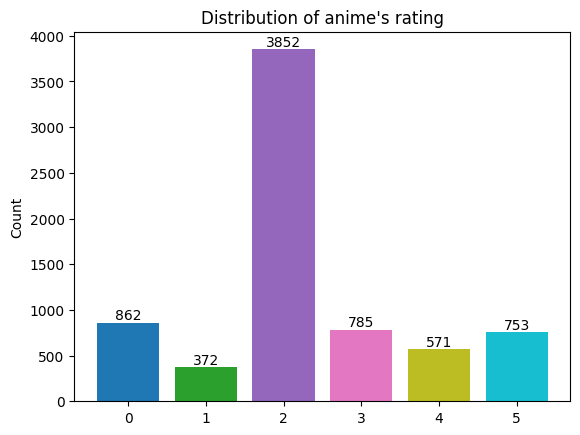

In [46]:
visualize(y_train.values)

We can see the anime's rating is imbalanced, the rating `PG-13 - Teens 13 or older` is very high (~3852), in constrast, the other ratings is very low (~900)

This cause the model's performance will not good or overfitting, so we have handle this imbalanced data

<h2 style="color: #EFD1B4;" id="imbalanced_data_handling">Imbalanced Data Handling</h2>

We use SMOTEENN for imbalanced data handling
- SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors) is a technique used to handle imbalanced data in classification tasks. It combines two methods: SMOTE (Synthetic Minority Over-sampling Technique) and ENN (Edited Nearest Neighbors), which helps improve model performance when there is a significant imbalance between classes.
- SMOTE (Synthetic Minority Over-sampling Technique): is a method for over-sampling the minority class in an imbalanced dataset. This technique generates new synthetic samples from existing minority class data points by interpolating between nearest neighbors.
- ENN (Edited Nearest Neighbors): ENN is a method for filtering and removing noisy data from the training set. Specifically, ENN checks the nearest neighbors of each data point, and if the point is misclassified by the majority of its neighbors, it is removed from the dataset.

In [47]:
# Kiểm tra phân bố các lớp ban đầu
print("Before SMOTEENN:")
print(y_train.value_counts())

Before SMOTEENN:
Rating_encoded
2    3852
0     862
3     785
5     753
4     571
1     372
Name: count, dtype: int64


Applying SMOTEENN for dataset

In [48]:
smote_enn = SMOTEENN(random_state=42, sampling_strategy = 'not majority')
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_train, y_train)

y_smoteenn_df = pd.DataFrame(y_smoteenn, columns=['Rating_encoded'])
X_smoteenn_df = pd.DataFrame(X_smoteenn, columns=X_train.keys())

Now, we visualize distribution of labels after applying SMOTEENN

C:\Users\MINH HUNG\AppData\Local\Temp\ipykernel_15432\1477781030.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_quality))


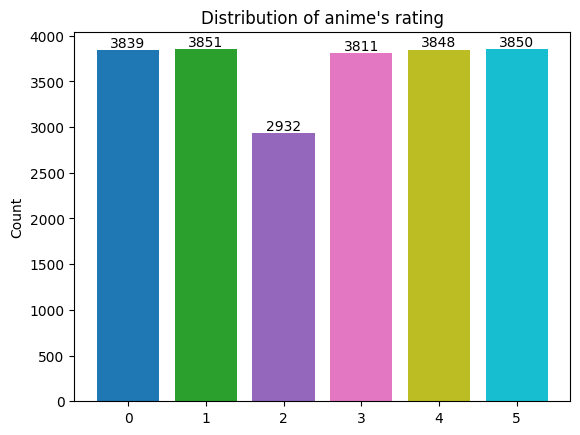

In [49]:
visualize(y_smoteenn_df.values)

The distribute looks like good, the label `PG-13 - Teens 13 or older` now is lower but it ok

In [50]:
X_clean_train, y_clean_train = X_smoteenn_df, y_smoteenn_df

In [51]:
X_clean_train

,Popularity,Favorites,Scored By,Members,abilities,ability,able,academy,accident,action,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,Rating_encoded
0,0.692079,0.000000,0.000053,0.000171,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.158885,0.000473,0.009263,0.012121,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.581605,0.000005,0.000104,0.000400,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.539865,0.000014,0.000204,0.000542,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0.684211,0.000005,0.000122,0.000181,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22126,0.370717,0.000111,0.000916,0.001776,0.0,0.0,0.000000,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,5
22127,0.285863,0.000373,0.001930,0.003405,0.0,0.0,0.000000,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,5
22128,0.345312,0.000040,0.001058,0.002090,0.0,0.0,0.014572,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,5
22129,0.548816,0.000007,0.000233,0.000558,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,5


<h2 style="color: #EFD1B4;" id="build_models">Build Models</h2>

Lets now build our models

In [53]:
model = ExtraTreesClassifier()
model.fit(X_clean_train, y_clean_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:',mae)

c:\Users\MINH HUNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Absolute Error: 0.11381322957198443


ETC Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       370
           1       0.83      0.51      0.63       160
           2       0.91      0.96      0.93      1651
           3       0.79      0.77      0.78       336
           4       0.94      0.80      0.86       245
           5       1.00      1.00      1.00       322

    accuracy                           0.90      3084
   macro avg       0.90      0.83      0.86      3084
weighted avg       0.90      0.90      0.90      3084



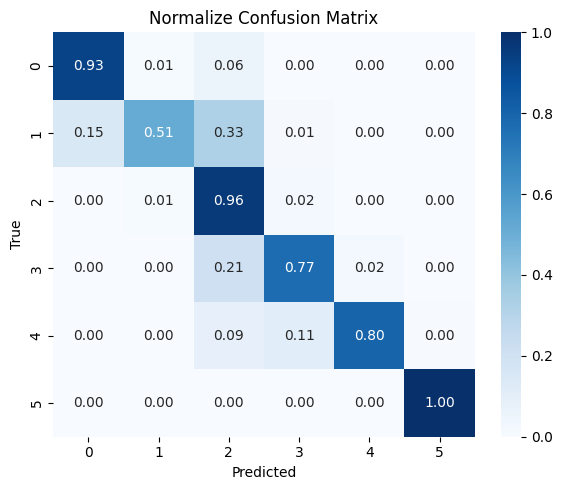

In [54]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f"ETC Classification Report:\n{class_report}")

# Plot Confusion Matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.title("Normalize Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
r2 = r2_score(y_pred,y_test)
print(r2)

0.903858404822072


In [ ]:
for i in range(20):
    print('Predicted: {:.2f};\n     Real: {};\n'.format(y_pred[i], y_test.iloc[i]))

Predicted: 5.00;
     Real: 5;

Predicted: 0.00;
     Real: 0;

Predicted: 2.00;
     Real: 2;

Predicted: 0.00;
     Real: 0;

Predicted: 0.00;
     Real: 0;

Predicted: 2.00;
     Real: 2;

Predicted: 2.00;
     Real: 2;

Predicted: 5.00;
     Real: 5;

Predicted: 2.00;
     Real: 2;

Predicted: 2.00;
     Real: 2;

Predicted: 2.00;
     Real: 2;

Predicted: 2.00;
     Real: 2;

Predicted: 4.00;
     Real: 4;

Predicted: 2.00;
     Real: 2;

Predicted: 2.00;
     Real: 2;

Predicted: 0.00;
     Real: 0;

Predicted: 5.00;
     Real: 5;

Predicted: 2.00;
     Real: 2;

Predicted: 5.00;
     Real: 5;

Predicted: 2.00;
     Real: 2;

